In [1]:
# Data Imports
import numpy as np
import pandas as pd
from pandas import Series,DataFrame
from collections import Counter
import math
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors
from sklearn import preprocessing
# Plot imports
import matplotlib.pyplot as plt
import seaborn as sns

# import knn model 
%matplotlib inline

In [2]:
# read in data 
title_df = pd.read_csv('Movies/title.basics.tsv/data.tsv', sep='\t')
#crew_df = pd.read_csv('Movies/title.crew.tsv/data.tsv', sep='\t')
ratings_df = pd.read_csv('Movies/title.ratings.tsv/data.tsv', sep='\t')

C:\Users\Lewis James\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
# view title data 
print(title_df.shape)
title_df.head()

(7918519, 9)


,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"


In [4]:
# describe title data 
title_df.describe()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
count,7918519,7918519,7918510,7918510,7918519,7918519,7918519,7918519,7918509
unique,7918519,10,3816982,3835235,11,256,96,846,2278
top,tt2381943,tvEpisode,Episode #1.1,Episode #1.1,0,\N,\N,\N,Drama
freq,1,5775158,39499,39499,7614322,867396,7841738,5707645,840982


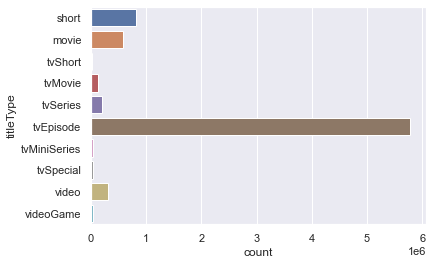

In [5]:
# visualize the data 
sns.set_theme(style="darkgrid")
ax = sns.countplot(y="titleType", data=title_df)

In [6]:
title_df_c = title_df[pd.notnull(title_df['tconst'])]
# remove runtimeMinutes = \N
title_df_c = title_df_c[title_df_c['runtimeMinutes'] != '\\N']

# remove fields = \N
title_df_c = title_df_c[title_df_c['genres'] != '\\N']
title_df_c = title_df_c[title_df_c['isAdult'] != '\\N']
title_df_c = title_df_c[title_df_c['startYear'] != '\\N']
title_df_c = title_df_c[title_df_c['runtimeMinutes'] != '\\N']

# only select movies 
title_df_c = title_df_c[title_df_c['titleType']=='movie']

print("The dataset now has: "+str(title_df_c.shape[0])+" observations.")

The dataset now has: 334985 observations.


In [7]:
# functions for creating feature vectors 

# feature extraction - get list column names 
def col_list(col_list): 

    genres = title_df_c['genres'].unique()
    final = []
    for cols in col_list:
        try:
            new  = cols.split(',')
            for element in new:
                final = np.append(str(element),final)
                final = np.unique(final)
        except Exception as e:
            print (str(e)+" the following didn't had an error "+str(genre))
    
    return final

# create a binary vector
def binary(listToCheck,fullList):
    binaryList = []
    
    for element in fullList:
        if element in listToCheck:
            binaryList.append(1)
        else:
            binaryList.append(0)
    
    return binaryList

In [8]:
# get the full list of genres 
fullGenreList = col_list(title_df_c['genres'].unique())
fullGenreList

array(['Action', 'Adult', 'Adventure', 'Animation', 'Biography', 'Comedy',
       'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'Film-Noir',
       'Game-Show', 'History', 'Horror', 'Music', 'Musical', 'Mystery',
       'News', 'Reality-TV', 'Romance', 'Sci-Fi', 'Short', 'Sport',
       'Talk-Show', 'Thriller', 'War', 'Western'], dtype='<U32')

In [9]:
# set feature vector - genre 
title_df_c['genreVector'] = title_df_c['genres'].apply(lambda x: binary(x.split(","),fullGenreList) )
title_df_c.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,genreVector
570,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0,1906,\N,70,"Action,Adventure,Biography","[1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
587,tt0000591,movie,The Prodigal Son,L'enfant prodigue,0,1907,\N,90,Drama,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
672,tt0000679,movie,The Fairylogue and Radio-Plays,The Fairylogue and Radio-Plays,0,1908,\N,120,"Adventure,Fantasy","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."
1172,tt0001184,movie,Don Juan de Serrallonga,Don Juan de Serrallonga,0,1910,\N,58,"Adventure,Drama","[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
1246,tt0001258,movie,The White Slave Trade,Den hvide slavehandel,0,1910,\N,45,Drama,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."


In [10]:
# view ratings data 
print(ratings_df.shape)
ratings_df.head()

(1153123, 3)


,tconst,averageRating,numVotes
0,tt0000001,5.7,1702
1,tt0000002,6.1,210
2,tt0000003,6.5,1460
3,tt0000004,6.2,123
4,tt0000005,6.2,2263


In [11]:
# merge dataframes 
final_df  = title_df_c.merge(ratings_df,how='inner',left_on='tconst', right_on='tconst')
final_df.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,genreVector,averageRating,numVotes
0,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0,1906,\N,70,"Action,Adventure,Biography","[1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6.1,633
1,tt0000591,movie,The Prodigal Son,L'enfant prodigue,0,1907,\N,90,Drama,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",5.2,6
2,tt0000679,movie,The Fairylogue and Radio-Plays,The Fairylogue and Radio-Plays,0,1908,\N,120,"Adventure,Fantasy","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...",5.2,35
3,tt0001184,movie,Don Juan de Serrallonga,Don Juan de Serrallonga,0,1910,\N,58,"Adventure,Drama","[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",3.4,11
4,tt0001258,movie,The White Slave Trade,Den hvide slavehandel,0,1910,\N,45,Drama,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",5.7,105


In [12]:
# feature vector
def constructFeatureVector(row):
    
    additionalFeatures = [row['isAdult'],row['startYear'],row['runtimeMinutes'],row['averageRating'],row['numVotes']]
    genreVector = row['genreVector']
    #featureVector = genreVector.append(additionalFeatures)
    featureVector = list(np.append(genreVector, additionalFeatures))
    featureVector = np.array(featureVector).astype(np.float)
    featureVector = featureVector.T
    return featureVector.tolist()

final_df['featureVector'] = final_df.apply(constructFeatureVector,axis=1)
final_df['featureVector']

0         [1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...
1         [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...
2         [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
3         [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...
4         [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...
                                ...                        
230929    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...
230930    [1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
230931    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
230932    [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...
230933    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...
Name: featureVector, Length: 230934, dtype: object

In [14]:
# feature scaling 
X_train = final_df.featureVector.tolist()
min_max_scaler = preprocessing.MinMaxScaler()
features = min_max_scaler.fit_transform(X_train)
features = np.round(features,2)
features

array([[1.  , 0.  , 1.  , ..., 0.  , 0.57, 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.47, 0.  ],
       [0.  , 0.  , 1.  , ..., 0.  , 0.47, 0.  ],
       ...,
       [0.  , 0.  , 0.  , ..., 0.  , 0.53, 0.  ],
       [0.  , 0.  , 1.  , ..., 0.  , 0.59, 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.81, 0.  ]])

In [15]:
# fit model 
nbrs = NearestNeighbors(n_neighbors=6, algorithm='brute').fit(features)
distances, indices = nbrs.kneighbors(features)

In [26]:
# functions to print recommended movies  
def get_index_from_title(originalTitle):
    return final_df[final_df["originalTitle"]==originalTitle].index.tolist()[0]

def print_similar(query):
        found_id = get_index_from_title(query)
        for id in indices[found_id][1:]:
            print(final_df.iloc[id]["originalTitle"])

In [27]:
# find candidate 
sorted_df  = final_df[['tconst','originalTitle','numVotes']].sort_values(by=['numVotes'], ascending=False)
sorted_df.head()

,tconst,originalTitle,numVotes
57262,tt0111161,The Shawshank Redemption,2391675
115734,tt0468569,The Dark Knight,2353908
144390,tt1375666,Inception,2112288
66133,tt0137523,Fight Club,1890885
57131,tt0110912,Pulp Fiction,1861292


In [29]:
print_similar('The Shawshank Redemption')

Fight Club
American Beauty
American History X
One Flew Over the Cuckoo's Nest
Requiem for a Dream


In [30]:
print_similar('The Dark Knight')

Léon
Kill Bill: Vol. 1
Baby Driver
Sicario
Man on Fire


In [31]:
print_similar('Inception')

The Avengers
Iron Man
Mad Max: Fury Road
Avengers: Infinity War
Star Wars: Episode VII - The Force Awakens


In [32]:
print_similar('Fight Club')

The Shawshank Redemption
American Beauty
American History X
One Flew Over the Cuckoo's Nest
Requiem for a Dream


In [33]:
print_similar('Pulp Fiction')

The Godfather
The Godfather: Part II
Scarface
Cidade de Deus
Taxi Driver
